# Taller 02: Clasificación Multiclase de Imágenes

**Objetivos:**

1. Realizar exploración del conjunto de datos
2. Extraer características usando un modelo preentrenado (ResNet50)
3. Entrenar una cabeza de clasificación usando AutoGluon
4. Evaluar el desempeño del modelo

**Estructura de directorios:**
```
data/labelme/
    train/
        class_1/
        class_2/
        ...
    test/
        class_1/
        class_2/
        ...
```
Descargar Dataset de https://www.ais.uni-bonn.de/download/datasets.html

## 1. Exploración del conjunto de datos

In [1]:
# Setup & Dependencies
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import glob
import torch.nn as nn
from tqdm import tqdm
from pathlib import Path
from torchvision import models, transforms
from torchvision.models import ResNet50_Weights
from torch.utils.data import DataLoader, Dataset
from autogluon.multimodal import MultiModalPredictor


In [2]:
# Selección de GPU si está disponible
if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print("Using device:", DEVICE)

Using device: mps


In [3]:
import os
import tarfile

archive = "LabelMe-12-50k.tar.gz"
extract_dir = os.path.join("data")

# Crea el directorio "data" si no existe
os.makedirs(extract_dir, exist_ok=True)

# Verifica si ya se extrajeron las carpetas 'train' y 'test'
if not (os.path.isdir(os.path.join(extract_dir, "train")) and os.path.isdir(os.path.join(extract_dir, "test"))):
    if not os.path.isfile(archive):
        print("Por favor, descarga LabelMe-12-50k.tar.gz en el directorio de trabajo.")
    else:
        print("Extrayendo dataset en 'data'...")
        with tarfile.open(archive, "r:gz") as tar:
            tar.extractall(path=extract_dir)
        print("Extracción completa.")
else:
    print("El dataset ya se encuentra extraído en", extract_dir)

El dataset ya se encuentra extraído en data


  class                        path
0  0003  data/train/0003/003301.jpg
1  0003  data/train/0003/003467.jpg
2  0003  data/train/0003/003473.jpg
3  0003  data/train/0003/003315.jpg
4  0003  data/train/0003/003329.jpg

Número de clases : 40
Imágenes por clase:
 class
0003    1000
0004    1000
0000    1000
0036    1000
0009    1000
0031    1000
0030    1000
0037    1000
0008    1000
0001    1000
0006    1000
0039    1000
0024    1000
0023    1000
0015    1000
0012    1000
0013    1000
0014    1000
0022    1000
0038    1000
0007    1000
0021    1000
0018    1000
0032    1000
0035    1000
0034    1000
0033    1000
0005    1000
0002    1000
0020    1000
0027    1000
0026    1000
0011    1000
0029    1000
0016    1000
0028    1000
0017    1000
0010    1000
0019    1000
0025    1000
Name: count, dtype: int64


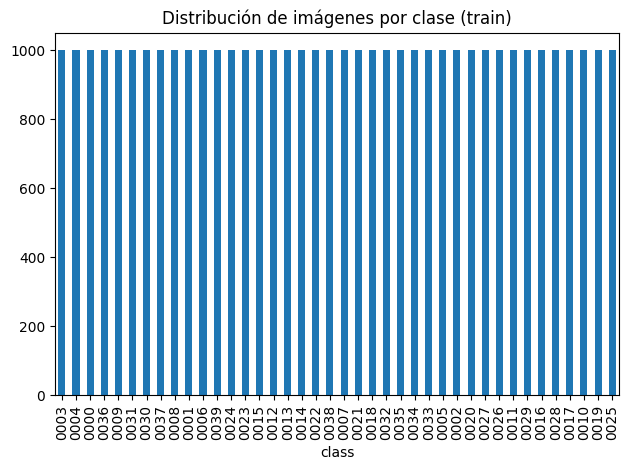

In [4]:
ROOT = Path("data/train")           # cambia a test para inspeccionar el split de test
IMAGE_GLOB_PATTERN = "*/*.jpg" 
image_paths = list(ROOT.glob(IMAGE_GLOB_PATTERN))    # adapta extensión si es .png o similar

df = pd.DataFrame({
    "class": [p.parent.name for p in image_paths],
    "path": image_paths
})

print(df.head())
print("\nNúmero de clases :", df['class'].nunique())
print("Imágenes por clase:\n", df['class'].value_counts())

# Distribución
plt.figure()
df['class'].value_counts().plot(kind='bar')
plt.title("Distribución de imágenes por clase (train)")
plt.tight_layout()
plt.show()

In [5]:
# Parse annotation files into DataFrames
# Annotation format: human-readable text files (annotation-train.txt, annotation-test.txt) with 12 floats per image + filename prefix ([kaggle.com](https://www.kaggle.com/datasets/dschettler8845/labelme-12-50k?utm_source=chatgpt.com))

def load_annotations(split):
    # Buscar el archivo de anotaciones dentro del directorio split
    ann_file_options = [
        os.path.join(extract_dir, split, f"annotation-{split}.txt"),
        os.path.join(extract_dir, split, "annotation.txt")
    ]
    
    ann_file = None
    for candidate in ann_file_options:
        if os.path.isfile(candidate):
            ann_file = candidate
            break
    if ann_file is None:
        raise FileNotFoundError(
            f"No se encontró un archivo de anotaciones válido para el split '{split}' en {os.path.join(extract_dir, split)}."
        )
    
    data = []
    with open(ann_file) as f:
        for line in f:
            parts = line.strip().split()
            img_name = parts[0] + ".jpg"
            vals = list(map(float, parts[1:]))
            label_idx = vals.index(1.0) if 1.0 in vals else 12
            # Buscar la imagen en cualquiera de las subcarpetas (por clase) dentro de <extract_dir>/<split>
            pattern = os.path.join(extract_dir, split, "*", img_name)
            matches = glob.glob(pattern)
            if not matches:
                raise FileNotFoundError(f"No se encontró la imagen {img_name} en {os.path.join(extract_dir, split)}")
            image_path = matches[0]
            data.append({
                "image": image_path,
                "label": label_idx
            })
    return pd.DataFrame(data)

# Cargar anotaciones para train y test
train_df = load_annotations("train")
test_df  = load_annotations("test")
print("Train size:", len(train_df), "Test size:", len(test_df))

Train size: 40000 Test size: 10000


In [6]:
train_df.head()

,image,label
0,data/train/0000/000000.jpg,4
1,data/train/0000/000001.jpg,1
2,data/train/0000/000002.jpg,2
3,data/train/0000/000003.jpg,1
4,data/train/0000/000004.jpg,1


In [7]:
# Define ResNet50 feature extractor
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

weights = ResNet50_Weights.IMAGENET1K_V1
resnet = models.resnet50(weights=weights)
feature_extractor = nn.Sequential(*list(resnet.children())[:-1]).to(DEVICE).eval()

# Custom Dataset to wrap images + transform
class ImageFeatureDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        from PIL import Image
        im = Image.open(row['image']).convert('RGB')
        im = self.transform(im)
        return im, int(row['label']), idx

In [8]:
# Extract & store features in DataFrame

def extract_features(df):
    ds = ImageFeatureDataset(df, transform)
    loader = DataLoader(ds, batch_size=32, shuffle=False, num_workers=0)
    features = np.zeros((len(ds), 2048), dtype=np.float32)
    labels = df['label'].values
    for images, _, idxs in tqdm(loader, desc="Extracting features"):
        images = images.to(DEVICE)
        with torch.no_grad():
            feats = feature_extractor(images).view(images.size(0), -1)
        features[idxs.numpy(), :] = feats.cpu().numpy()
    # return new DataFrame
    feat_df = pd.DataFrame(features, columns=[f"f{i}" for i in range(2048)])
    feat_df['label'] = labels
    return feat_df

train_feat_df = extract_features(train_df)
test_feat_df  = extract_features(test_df)
print(train_feat_df.shape, test_feat_df.shape)

Extracting features: 100%|██████████| 313/313 [00:48<00:00,  6.45it/s]

(40000, 2049) (10000, 2049)


In [9]:
# Save feature files (optional)
train_feat_df.to_csv("data/features_train.tsv", index=False)
test_feat_df.to_csv("data/features_test.tsv", index=False)
print("Features saved to TSV.")

Features saved to TSV.


In [18]:
#Train numerical MLP head in AutoGluon-Multimodal

predictor = MultiModalPredictor(
    label='label',
    problem_type='multiclass',
    path='automm_labelme_features_3',
    presets='high_quality',
    pretrained=False  # use only numerical MLP head
)
predictor.fit(
    train_data=train_feat_df,
    tuning_data=test_feat_df,
    time_limit=1800,
    hyperparameters={
        'model.names': ['numerical_mlp'],
        'env.per_gpu_batch_size': 32,
        'optimization.learning_rate': 1e-3,
        'optimization.max_epochs': 30
    }
)

=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.16
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.4.0: Fri Apr 11 18:33:47 PDT 2025; root:xnu-11417.101.15~117/RELEASE_ARM64_T6030
CPU Count:          11
Pytorch Version:    2.5.1
CUDA Version:       CUDA is not available
Memory Avail:       5.38 GB / 18.00 GB (29.9%)
Disk Space Avail:   275.13 GB / 460.43 GB (59.8%)

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3
    ```

Seed set to 0
GPU Count: 0
GPU Count to be Used: 0

/opt/anaconda3/envs/autogluon-env/lib/python3.10/site-packages/autogluon/multimodal/utils/environment.py:131: UserWarning: Only CPU is detected in the instance. This ma

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 156: 'val_accuracy' reached 0.75080 (best 0.75080), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=0-step=156.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 313: 'val_accuracy' reached 0.81010 (best 0.81010), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=0-step=313.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 469: 'val_accuracy' reached 0.82730 (best 0.82730), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=1-step=469.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 626: 'val_accuracy' reached 0.83800 (best 0.83800), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=1-step=626.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 782: 'val_accuracy' reached 0.83630 (best 0.83800), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=2-step=782.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 939: 'val_accuracy' reached 0.84640 (best 0.84640), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=2-step=939.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 1095: 'val_accuracy' reached 0.84350 (best 0.84640), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=3-step=1095.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 1252: 'val_accuracy' reached 0.85100 (best 0.85100), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=3-step=1252.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 1408: 'val_accuracy' reached 0.85540 (best 0.85540), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=4-step=1408.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 1565: 'val_accuracy' reached 0.85390 (best 0.85540), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=4-step=1565.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 1721: 'val_accuracy' reached 0.85720 (best 0.85720), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=5-step=1721.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 1878: 'val_accuracy' reached 0.85730 (best 0.85730), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=5-step=1878.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 2034: 'val_accuracy' reached 0.85640 (best 0.85730), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=6-step=2034.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 2191: 'val_accuracy' reached 0.86020 (best 0.86020), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=6-step=2191.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 2347: 'val_accuracy' reached 0.85990 (best 0.86020), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=7-step=2347.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 2504: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 2660: 'val_accuracy' reached 0.86010 (best 0.86020), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=8-step=2660.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 2817: 'val_accuracy' reached 0.86160 (best 0.86160), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=8-step=2817.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 2973: 'val_accuracy' reached 0.86170 (best 0.86170), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=9-step=2973.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 3130: 'val_accuracy' reached 0.86120 (best 0.86170), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=9-step=3130.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 3286: 'val_accuracy' reached 0.86380 (best 0.86380), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=10-step=3286.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, global step 3443: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 3599: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11, global step 3756: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 3912: 'val_accuracy' reached 0.86170 (best 0.86380), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=12-step=3912.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12, global step 4069: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 4225: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13, global step 4382: 'val_accuracy' reached 0.86380 (best 0.86380), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=13-step=4382.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 4538: 'val_accuracy' reached 0.86200 (best 0.86380), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=14-step=4538.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14, global step 4695: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 4851: 'val_accuracy' reached 0.86480 (best 0.86480), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=15-step=4851.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15, global step 5008: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 5164: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16, global step 5321: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 5477: 'val_accuracy' reached 0.86500 (best 0.86500), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=17-step=5477.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17, global step 5634: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 5790: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18, global step 5947: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 6103: 'val_accuracy' reached 0.86430 (best 0.86500), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=19-step=6103.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19, global step 6260: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 6416: 'val_accuracy' reached 0.86450 (best 0.86500), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=20-step=6416.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20, global step 6573: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 6729: 'val_accuracy' reached 0.86500 (best 0.86500), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=21-step=6729.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21, global step 6886: 'val_accuracy' reached 0.86510 (best 0.86510), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=21-step=6886.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 7042: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22, global step 7199: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 7355: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23, global step 7512: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 7668: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24, global step 7825: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 7981: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25, global step 8138: 'val_accuracy' reached 0.86520 (best 0.86520), saving model to '/Users/cristianblandon/projects/computerVision/Taller02-clasificacion/automm_labelme_features_3/epoch=25-step=8138.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 8294: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26, global step 8451: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 8607: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27, global step 8764: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 8920: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28, global step 9077: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 9233: 'val_accuracy' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29, global step 9390: 'val_accuracy' was not in top 3
`Trainer.fit` stopped: `max_epochs=30` reached.
Start to fuse 3 checkpoints via the greedy soup algorithm.
/opt/anaconda3/envs/autogluon-env/lib/python3.10/site-packages/autogluon/multimodal/learners/base.py:2117: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any us

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/envs/autogluon-env/lib/python3.10/site-packages/autogluon/multimodal/utils/checkpoint.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/envs/autogluon-env/lib/python3.10/site-packages/autogluon/multimodal/utils/checkpoint.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.

Predicting: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/envs/autogluon-env/lib/python3.10/site-packages/autogluon/multimodal/utils/checkpoint.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.

In [19]:
# Evaluate & Predict
results = predictor.evaluate(test_feat_df)
print("Evaluation results:", results)
preds = predictor.predict(test_feat_df.drop(columns='label'))
print("Sample predictions:", preds[:10])

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


Predicting: |          | 0/? [00:00<?, ?it/s]

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.


Evaluation results: {'accuracy': 0.8661}


Predicting: |          | 0/? [00:00<?, ?it/s]

Sample predictions: 0     1
1    12
2     1
3     1
4    12
5     1
6    12
7     3
8    12
9    12
Name: label, dtype: int64


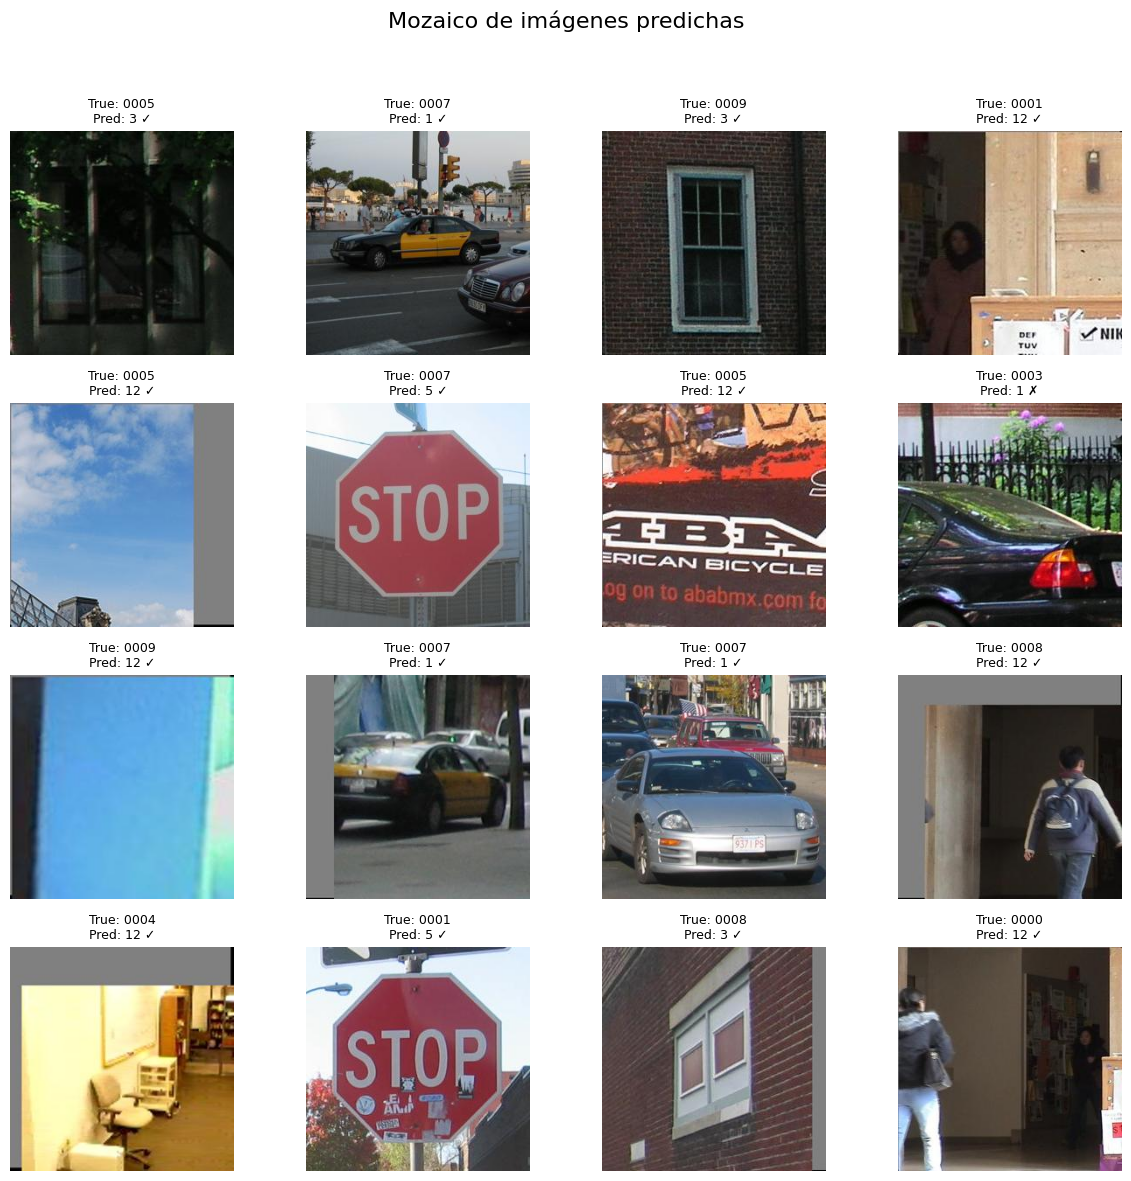

In [21]:
import matplotlib.pyplot as plt
from PIL import Image
import random
import os

# Seleccionar aleatoriamente 16 imágenes del conjunto de test
sample_indices = random.sample(range(len(test_df)), 24)

fig, axes = plt.subplots(4, 4, figsize=(12,12))
fig.suptitle("Mozaico de imágenes predichas", fontsize=16)

for idx, ax in zip(sample_indices, axes.flatten()):
    img_path = test_df.iloc[idx]['image']
    true_label_int = test_df.iloc[idx]['label']
    # Asumimos que el label verdadero se extrae del nombre de la carpeta de la imagen
    # (p.ej. data/train/class_1/... => true_label_name = "class_1")
    true_label_name = os.path.basename(os.path.dirname(img_path))
    
    # Predicción para la misma imagen (asumiendo que el orden se mantiene)
    pred_label = preds[idx]
    
    # Cargar la imagen con PIL
    im = Image.open(img_path).convert('RGB')
    ax.imshow(im)
    ax.axis('off')
    
    # Mostrar título con el label verdadero y el label predicho.
    # Si coinciden, se muestra un check, de lo contrario una X.
    correctness = "✓" if str(pred_label) == str(true_label_int) else "✗"
    ax.set_title(f"True: {true_label_name}\nPred: {pred_label} {correctness}", fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()